In [30]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import sklearn.feature_extraction.text as sktext
import sklearn.neighbors as skneigh
import scipy
import seaborn as sns
from sklearn.manifold import TSNE

%matplotlib inline

In [96]:
def attr_parser(item_attrs, cat_attrs):
    # Parsea los atributes preservando orden
    parsed = []
    for base_attr in cat_attrs:
        attr_id = base_attr['id'] 

        # Look for attribute
        attribute_found = False
        for attr in item_attrs:
            if attr['id'] == attr_id:
                value_type = base_attr['value_type']
                try:
                    if   value_type == 'number':
                        parsed.append(float(attr['value_name']))
                    elif value_type == 'number_unit':
                        # TODO: conversor de unidades
                        parsed.append(attr['value_struct']['number']) 
                    elif value_type == 'string':
                        # TODO: apply tokenizer to attribute
                        parsed.append(float(attr['value_id']))
                    elif value_type == 'boolean':
                        parsed.append(1.0 if attr['value_id']=='242085' else 0.0)
                    elif value_type == 'list':
                        # TODO: implement list parsing
                        parsed.append(0.0)
                except:
                    parsed.append(0.0)
                
                attribute_found = True
                break

        # Attribute not found
        if not attribute_found:
            parsed.append(0.0)
    
    return parsed

In [52]:
# Target
site_id = 'MLA'

example = 'pila'
item_id = f'{site_id}1100783124'

example = 'multiproc'
item_id = f'{site_id}1101556021'

In [108]:
# 1 - Get item
# Extract info from target item
url  = f'https://api.mercadolibre.com/items/{item_id}'
req  = requests.get(url)
info = req.json()
#req  = requests.get(url+'/description')
#desc = req.json()['plain_text']
target = info['title']
print(target)

Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v


Obtengo la categoría y busco sus atributos. Para expandir el universo de posibilidades una opción podría ser buscar en que otras categorías se podría encontrar el item mediante la funcioón de _domain discovery_ de la API

In [49]:
# 2 - Get categoy and attributes
cat_id = info['category_id']
url = f'https://api.mercadolibre.com/categories/{cat_id}/attributes'
req = requests.get(url)
cat_attrs = req.json()

In [50]:
# 3 - Get items in categories
limit = 50
items = []

url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}'
req = requests.get(url)
total = req.json()['paging']['total']
if total>1000: total = 1000 # Sin AUTHTOKEN no deja ver más de 1000 registros
    
total = 200 ##### ACTUALIZAR ESTO DESPUES

items = items + req.json()['results']
for offset in range(limit, total, limit):
    url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}&offset={offset}'
    req = requests.get(url)
    items = items + req.json()['results']

Se podría crear un diccionario más grande viendo las descripciones en /items/{item_id}/description

In [99]:
# Extract features from items
titles = []
attributes  = []
for unit in items:
    url  = f'https://api.mercadolibre.com/items/{unit["id"]}'
    req  = requests.get(url)
    info = req.json()
    try:
        titles.append(info['title'])
        attributes.append(attr_parser(info['attributes'], cat_attrs))
    except KeyError:
        pass
attributes = np.array(attributes)

In [72]:
info

{'message': 'Oops! Something went wrong...',
 'error': 'internal_server_error',
 'status': 500,
 'cause': []}

In [53]:
np.save(f'titles_{example}', titles)
np.save(f'attris_{example}', attributes)
#titles = np.load(f'titles_{example}.npy')
#attributes = np.load(f'attris_{example}.npy')

/home/pato/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [54]:
count_vect = sktext.CountVectorizer()
tfidf_tran = sktext.TfidfTransformer()

X = count_vect.fit_transform(titles)
X = tfidf_tran.fit_transform(X)

In [55]:
nnalg = skneigh.NearestNeighbors()
nnalg.fit(X)

NearestNeighbors()

In [56]:
ll=[]

predict = count_vect.transform([target])
X_tfidf2 = tfidf_tran.transform(predict)
ll.append(X_tfidf2)

ll = scipy.sparse.vstack((ll))
res = nnalg.kneighbors(ll, return_distance=False)

In [57]:
res

array([[ 19, 130, 110, 157,  10]])

In [58]:
array(titles)[res[0]]

array(['Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v',
       'Procesadora De Alimentos Smartlife Sl-fp0509 1000w Acero ',
       'Multiprocesadora Smartlife Licuadora  Acero Inoxidable 1000w',
       'Multiprocesadora Smartlife Con Licuadora 1000w Fp509 Acero',
       'Multiprocesadora Liliana Fullpros Am790 1000w Negra 220v - 240v'],
      dtype='<U79')

In [59]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

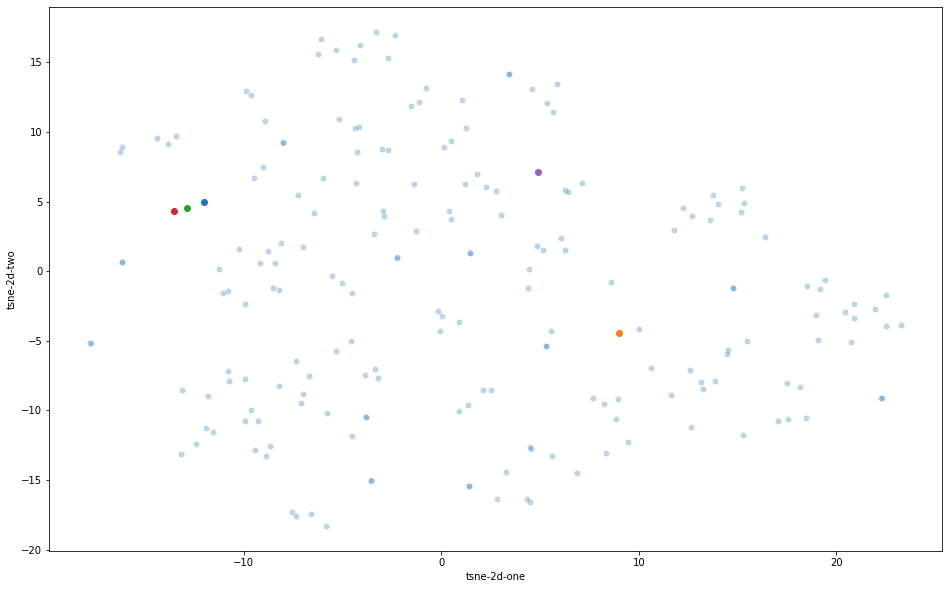

In [60]:
data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)
for ii in res[0]:
    plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'o')


In [102]:
nnalg = skneigh.NearestNeighbors()
nnalg.fit(attributes)

NearestNeighbors()

In [109]:
target_attr = np.array(attr_parser(info['attributes'], cat_attrs)).reshape(1,-1)
shape(target_attr)

(1, 51)

In [110]:
res = nnalg.kneighbors(target_attr, return_distance=False)

In [107]:
res

(array([[   0.        ,    0.        , 3368.37126814, 3368.37171345,
         3368.44391522]]),
 array([[170, 198,  13, 131, 103]]))

In [111]:
array(titles)[res[0]]

array(['Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v',
       'Multiprocesadora Smartlife Con Licuadora 1000w Fp509 Acero',
       'Multiprocesadora Smartlife Licuadora  Acero Inoxidable 1000w',
       'Procesadora De Alimentos Smartlife Sl-fp0509 1000w Acero ',
       'Multiprocesadora Electrolux 600w 1,2lt 3 Vel Fpl21 Licuadora'],
      dtype='<U79')